# *Summary*

### This notebook is an extension of the credit risk modelling from logistic regression.

### In this notebook, the credit risk modelled with gradient boosted trees for predicting loan defaults with probability. This can be used to automate approving and declining loan applcations more accurately.

### An 93.3% accuracy level was achieved in predicting the loan defaults on 32,576 loans and 12 benchmarks with a probability threshold of 60%. With this model, the default rate would decrease from 21.8% to 6.7%, resulting in minimized risk for both the lender and applicant.
   


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import model_selection,linear_model, metrics
import xgboost as xgb

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv


In [2]:
cr_data = pd.read_csv("/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv")

emp_len_null = cr_data[cr_data['person_emp_length'].isnull()].index
int_rate_null = cr_data[cr_data['loan_int_rate'].isnull()].index

cr_data['person_emp_length'].fillna((cr_data['person_emp_length'].median()), inplace=True)
cr_data['loan_int_rate'].fillna((cr_data['loan_int_rate'].median()), inplace = True)

cr_data = cr_data.rename(columns = {"cb_person_default_on_file":"default_hist", "cb_person_cred_hist_length": "cr_hist_len"})

cr_clean1 = cr_data[cr_data['person_age']<=100]

# one hot encoding categorical variables
num_col = cr_clean1.select_dtypes(exclude = 'object')
char_col = cr_clean1.select_dtypes(include = 'object')

encoded_char_col = pd.get_dummies(char_col)

cr_clean2 = pd.concat([num_col, encoded_char_col], axis=1)
cr_clean2

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cr_hist_len,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,default_hist_N,default_hist_Y
0,22,59000,123.0,35000,16.02,1,0.59,3,0,0,...,0,0,0,0,1,0,0,0,0,1
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,30,1,0,...,0,0,0,1,0,0,0,0,1,0
32577,54,120000,4.0,17625,7.49,0,0.15,19,1,0,...,0,1,0,0,0,0,0,0,1,0
32578,65,76000,3.0,35000,10.99,1,0.46,28,0,0,...,0,0,1,0,0,0,0,0,1,0
32579,56,150000,5.0,15000,11.48,0,0.10,26,1,0,...,0,0,1,0,0,0,0,0,1,0


In [3]:
# Split Train and Test Sets
Y = cr_clean2['loan_status']
X = cr_clean2.drop('loan_status',axis=1)
 


x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, random_state=2020, test_size=.30)

#Start of gradient boosted tree

xgb_model = xgb.XGBClassifier() # initialize tree

xgb_model.fit(x_train, np.ravel(y_train)) # train tree

predict_xgb = xgb_model.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

predict_xgb_prob = pd.DataFrame(predict_xgb[:,1],columns = ['Default Probability'])

pd.concat([predict_xgb_prob, y_test.reset_index(drop=True)],axis=1)


,Default Probability,loan_status
0,0.021063,0
1,0.002830,0
2,0.003708,0
3,0.003818,0
4,0.077810,0
...,...,...
9768,0.070766,0
9769,0.020037,0
9770,0.999367,1
9771,0.027434,0


In [4]:
print("There are {} features in cr_clean2".format(cr_clean2.shape[1]))
round(xgb_model.score(x_test,y_test),3)

There are 27 features in cr_clean2


0.935

In [5]:
feat_imp = xgb_model.get_booster().get_score(importance_type='weight')
feat_imp

{'loan_percent_income': 278,
 'loan_int_rate': 439,
 'person_income': 803,
 'loan_grade_D': 46,
 'loan_intent_HOMEIMPROVEMENT': 41,
 'loan_grade_E': 36,
 'person_emp_length': 247,
 'loan_intent_MEDICAL': 84,
 'loan_intent_DEBTCONSOLIDATION': 55,
 'cr_hist_len': 156,
 'loan_grade_C': 39,
 'person_home_ownership_OWN': 48,
 'person_home_ownership_RENT': 66,
 'person_home_ownership_OTHER': 3,
 'loan_intent_EDUCATION': 37,
 'loan_intent_PERSONAL': 30,
 'person_age': 277,
 'loan_amnt': 352,
 'person_home_ownership_MORTGAGE': 41,
 'loan_grade_A': 18,
 'loan_intent_VENTURE': 36,
 'loan_grade_B': 33,
 'loan_grade_G': 15,
 'default_hist_N': 19,
 'loan_grade_F': 12}

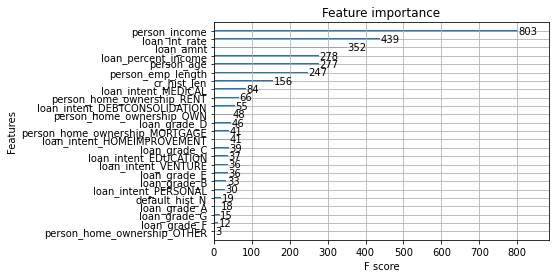

In [6]:
xgb.plot_importance(xgb_model,importance_type='weight')

In [7]:

remove_feats = []

for key in feat_imp.keys():
    if feat_imp[key] < 40:    # tried 
        remove_feats.append(key)
        
imp_data = X
for key in remove_feats:
    imp_data = imp_data.drop(key,axis=1)

In [8]:
imp_data.shape

(32576, 15)

The data has been reduced to 15 important features

In [9]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(imp_data, Y, random_state=2020, test_size=.30)

#Start of gradient boosted tree

xgb_model = xgb.XGBClassifier() # initialize tree

xgb_model.fit(x_train, np.ravel(y_train)) # train tree

predict_xgb = xgb_model.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

predict_xgb_prob = pd.DataFrame(predict_xgb[:,1],columns = ['Default Probability'])

pd.concat([predict_xgb_prob, y_test.reset_index(drop=True)],axis=1)


,Default Probability,loan_status
0,0.019816,0
1,0.001572,0
2,0.087558,0
3,0.001251,0
4,0.078030,0
...,...,...
9768,0.046194,0
9769,0.015422,0
9770,0.998609,1
9771,0.030456,0


In [10]:
round(xgb_model.score(x_test,y_test),3)

0.932

In [11]:
thresh = np.linspace(0,1,21)
thresh

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [12]:
def find_opt_thresh(predict,thr =thresh, y_true = y_test):
    data = predict
    
    def_recalls = []
    nondef_recalls = []
    accs =[]

    
    for threshold in thr:
        # predicted values for each threshold
        data['loan_status'] = data['Default Probability'].apply(lambda x: 1 if x > threshold else 0 )
        
        accs.append(metrics.accuracy_score(y_true, data['loan_status']))
        
        stats = metrics.precision_recall_fscore_support(y_true, data['loan_status'])
        
        def_recalls.append(stats[1][1])
        nondef_recalls.append(stats[1][0])
        
        
    return accs, def_recalls, nondef_recalls

accs, def_recalls, nondef_recalls= find_opt_thresh(predict_xgb_prob)


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


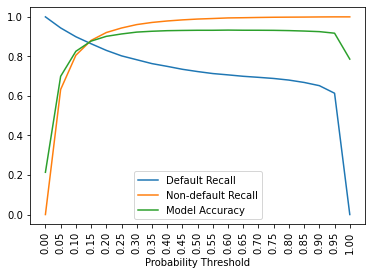

In [13]:
plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.xticks(thresh, rotation = 'vertical')
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
#plt.axvline(x=0.45, color='pink')
plt.show()

In [14]:
optim_threshold = accs.index(max(accs))

print(round(accs[optim_threshold],3))

thresh[optim_threshold]

0.933


0.6000000000000001

In [15]:
cr_clean2.shape[1] - imp_data.shape[1]
# num of total features (including dummies) subtract important features with F score >= 40

12

In [16]:
# original loan defaults by previous default history
default_hist_status_tab= pd.crosstab(cr_clean1['default_hist'], cr_clean1['loan_status'])
default_hist_status_tab

loan_status,0,1
default_hist,,
N,21895,4936
Y,3573,2172


In [17]:
round(default_hist_status_tab.iloc[:,1].sum() /cr_data.shape[0],3)

0.218

**The accuracy of the model was 93.3% with 15 important features and 12 feature removed once the data had been cleaned and encoded.**

**The gradient boosted tree performed 7.3% better than the logistics regression and had a higher probability threshold for default by 15%.**

**The initial loan default rate was 21.8%. With the `xgb_model`, the loan default rate should decrease to 6.7%. With this 15.1% improvement in default rate the lenders and applicants are even more so protected from risk.**